## Identifications

---

### Imports

In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import matplotlib.colors as mc
import random
from astropy.cosmology import FlatLambdaCDM
from matplotlib.patches import Rectangle
from tqdm import tqdm
from scipy.stats import cumfreq
from collections import Counter
from lmfit import Model
from scipy.stats import binned_statistic
from functools import partial
from astropy.constants import c
from astropy import units as u
from labellines import labelLines
from matplotlib.colors import LinearSegmentedColormap
from itertools import chain
utils.rcparams()

In [2]:
# Load the Herschel, COSMOS2020 and matched VLA data sets
herschel = utils.full_loader('Herschel')
cosmos2020 = utils.full_loader('COSMOS2020')
vla = utils.full_loader('VLA_COSMOS2020_05')

# Add redshift errors to VLA data
vla['lp_zPDF_low'] = vla['lp_zPDF']-vla['lp_zPDF_l68']
vla['lp_zPDF_high'] = vla['lp_zPDF_u68']-vla['lp_zPDF']
vla['lp_zPDF_err'] = (vla['lp_zPDF_low']+vla['lp_zPDF_high'])/2

# Define the cosmology used throughout
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

/Users/bradleyward/Desktop/PhD/PhD_Projects/Thesis-Chapter-5-Radio-Sources/utils/loader.py:24: DtypeWarning: Columns (591) have mixed types. Specify dtype option on import or set low_memory=False.
  data = read_csv(file_path)


---

### Create COSMOS Survey

In [3]:
# Define parameter files for sources and counterparts
source_params = {'data': herschel,
                 'name': 'id_her',
                 'ra': 'RA_her',
                 'dec': 'Dec_her',
                 'wavelengths_obs_um': np.array([250,350,500]),
                 'fluxes': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500'],
                 'flux_errors': ['FErr_BLIND_MF_SPIRE_250', 'FErr_BLIND_MF_SPIRE_350', 'FErr_BLIND_MF_SPIRE_500']}

counterpart_params = {'data': vla,
                      'name': 'id_cos',
                      'ra': 'RA_cos',
                      'dec': 'Dec_cos',
                      'fluxes': ['total_int_flux'],
                      'redshift': 'lp_zPDF',
                      'redshift_err': 'lp_zPDF_err'}

In [4]:
# Create Herschel and VLA objects and generate COSMOS survey
herschel_objects, vla_objects = utils.create_sources_and_counterparts(source_params, counterpart_params)
cosmos = utils.Survey(herschel_objects, vla_objects)
print('Region being used: RA - {:.3f} to {:.3f}, DEC - {:.3f} to {:.3f}'.format(cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max))
print('Area of Overlapping Region = {:.2f} deg2'.format(cosmos.area_deg))

Creating Sources:  15%|█▌        | 1690/11185 [00:00<00:02, 4483.75it/s]

Creating Counterparts: 100%|██████████| 10830/10830 [00:01<00:00, 8938.53it/s]

Input Number of Sources = 11185
Input Number of Counterparts = 10830
Overlapping Number of Sources = 7230 (64.64%)
Overlapping Number of Counterparts = 10826 (99.96%)
Region being used: RA - 149.289 to 150.952, DEC - 1.452 to 3.038
Area of Overlapping Region = 2.64 deg2


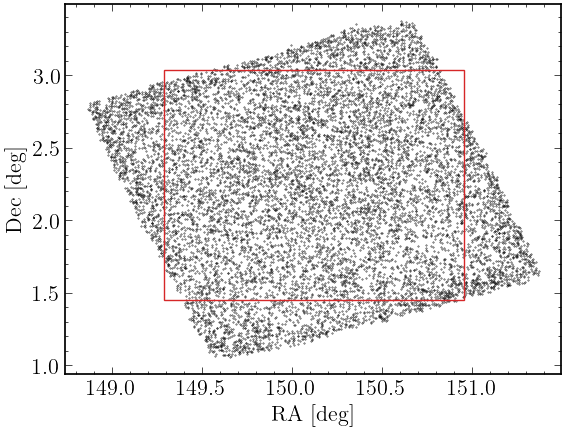

In [5]:
# Obtain location of Herschel objects
herschel_ras = [herschel_objects[it].ra for it in range(len(herschel_objects))]
herschel_decs = [herschel_objects[it].dec for it in range(len(herschel_objects))]

fig, ax = plt.subplots()
ax.scatter(herschel_ras, herschel_decs, s=0.1)
ax.add_patch(Rectangle((cosmos.ra_min, cosmos.dec_min), cosmos.ra_max-cosmos.ra_min, cosmos.dec_max-cosmos.dec_min, edgecolor='tab:red', facecolor='none'))
ax.set_xlabel(r'RA [deg]')
ax.set_ylabel(r'Dec [deg]')
plt.savefig(utils.ROOT+'/figures/Figure_5_1.pdf', dpi=1000)
plt.show()

---

### Defining the Optimal Search Radius

In [6]:
# Define the number of random sources to create
N = len(cosmos.sources)
r_max_arcsec = 30
rand_sources = utils.random_sources(N, cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max)

# Set up arrays for radial separations
rand_r = []
herschel_r = []

# For all possible candidates around random sources append their separation
for source in tqdm(rand_sources, desc='Random Sources'):
    r_max_deg = r_max_arcsec/3600
    ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
    possible_counterparts = [counterpart for counterpart in cosmos.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
    for counterpart in possible_counterparts:
        r = counterpart.separation(source)
        if r <= r_max_arcsec:
            rand_r.append(r)

# For all possible candidates around Herschel sources append their separation
for source in tqdm(cosmos.sources, desc='Herschel Sources'):
    r_max_deg = r_max_arcsec/3600
    ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
    possible_counterparts = [counterpart for counterpart in cosmos.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
    for counterpart in possible_counterparts:
        r = counterpart.separation(source)
        if r <= r_max_arcsec:
            herschel_r.append(r)

# Generate histograms of separations
rand_r_hist, bin_edges = np.histogram(rand_r, bins=30, range=(0,30))
herschel_r_hist, _ = np.histogram(herschel_r, bins=30, range=(0,30))
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

# Generate cumulative frequency arrays from separations
rand_r_cum = cumfreq(rand_r, 30, defaultreallimits=(0,30))
herschel_r_cum = cumfreq(herschel_r, 30, defaultreallimits=(0,30))
rand_r_freq = np.array(rand_r_cum.cumcount)
herschel_r_freq = np.array(herschel_r_cum.cumcount)

Random Sources:   4%|▍         | 287/7230 [00:00<00:04, 1443.30it/s]

Herschel Sources: 100%|██████████| 7230/7230 [00:04<00:00, 1701.51it/s]


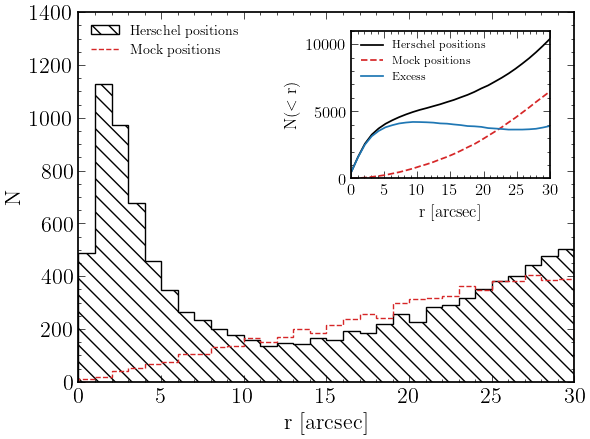

In [7]:
r_range = np.linspace(0,30,30)

# Plot of radial separations and cumulative counts
fig, ax = plt.subplots()
ax.stairs(herschel_r_hist, bin_edges, hatch=r'\\', label=r'Herschel positions')
ax.stairs(rand_r_hist, bin_edges, linestyle='--', label=r'Mock positions', color='tab:red')

axin = ax.inset_axes([0.55,0.55,0.4,0.4])
axin.plot(r_range, herschel_r_freq, label=r'Herschel positions')
axin.plot(r_range, rand_r_freq, linestyle='--', color='tab:red', label=r'Mock positions')
axin.plot(r_range, herschel_r_freq-rand_r_freq, color='tab:blue', label=r'Excess')
axin.set_xlabel(r'r [arcsec]', fontsize=12)
axin.set_ylabel(r'N($<$ r)', fontsize=12)
axin.tick_params(axis='both', labelsize=12)
axin.set_xticks([0,5,10,15,20,25,30])
axin.set_xlim(0,30)
axin.set_ylim(0,11000)
axin.legend(fontsize=8)

ax.set_xlim(0,30)
ax.set_ylim(0,1400)
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.legend(loc='upper left', fontsize=10)
plt.savefig(utils.ROOT+'/figures/Figure_5_2.pdf', dpi=1000)
plt.show()

---

### Estimate of the Maximum P Value

Expected maximum P based on Poisson statistics:
Let X be the number of VLA sources observed within a single search radius

$$\lambda = N_{\textrm{VLA}}A_{\textrm{Circle}}/A_{\textrm{Survey}}$$

\begin{align}
    P_{\textrm{max}} &\sim \frac{P(\textrm{Not-blank})}{P(\textrm{Blank})} \\
    &= \frac{P(X > 0)}{P(X = 0)} \\
    &= \frac{1-P(X = 0)}{P(X = 0)} \\
    &= \frac{1-e^{-\lambda}}{e^{-\lambda}}
\end{align}

In [8]:
# Expected maximum P value (ignoring overlapping regions and assuming Poisson statistics)
r_max = 10
N_vla = len(cosmos.counterparts)
a_circle = np.pi*(r_max**2)
a_survey = cosmos.area_arcsec
lam = (N_vla*a_circle)/a_survey
prob_max = (1-np.exp(-lam))/(np.exp(-lam))
print('The number density of VLA objects = {:.2f} per square degree'.format(N_vla/cosmos.area_deg))
print('The maximum probability is expected to be approximately = {:.2f}'.format(prob_max))

The number density of VLA objects = 4103.01 per square degree
The maximum probability is expected to be approximately = 0.10


---

### Creating COSMOS Sample

In [9]:
# Defining maximum r and P values and generating D(S) distributions
r_max = 10
p_max = 0.05
herschel_ds = cosmos.get_s_values(r_max_arcsec=r_max)
random_ds, herschel_vla = cosmos.get_groups(r_max_arcsec=r_max, p_max=p_max, n=1000000)

Calculating P Values: 100%|██████████| 7230/7230 [00:51<00:00, 141.63it/s]


/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_16181/4071624946.py:6: RuntimeWarning: divide by zero encountered in log10
  ax.hist(np.log10(random_ds), bins=200, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)


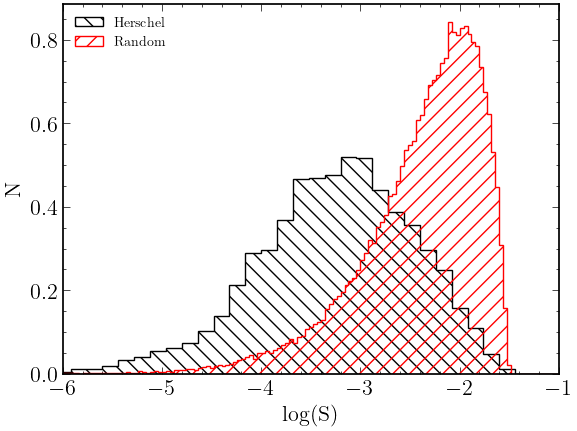

In [10]:
logs_range = (-8,0)

# Plot of the D(S) distributions
fig, ax = plt.subplots()
ax.hist(np.log10(herschel_ds), bins=50, range=logs_range, histtype='step', hatch=r'\\', label=r'Herschel', density=True)
ax.hist(np.log10(random_ds), bins=200, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)
ax.set_xlabel(r'log(S)')
ax.set_ylabel(r'N')
ax.set_xlim(-6,-1)
ax.legend(fontsize=10, loc='upper left')
plt.savefig(utils.ROOT+'/figures/Figure_5_3.pdf', dpi=1000)
plt.show()

In [11]:
# Apply a flux limit on samples
flux_limit = 0.03
herschel_vla_flux = utils.apply_flux_limit(herschel_vla, flux_limit)

#### Important Statistics and ID Fraction

In [12]:
# Number of sources and counterparts
n_sources = len(cosmos.sources)
n_counterparts = len(cosmos.counterparts)
n_sources_flux = len([source for source in cosmos.sources if source.fluxes[0] > flux_limit])

# Number of primary IDs 
n_ids = len(herschel_vla['primaries'])
n_ids_flux = len(herschel_vla_flux['primaries'])

# Number of expected false IDs
n_false = np.sum([pair.p for pair in herschel_vla['primaries']])
n_false_flux = np.sum([pair.p for pair in herschel_vla_flux['primaries']])

print('The number of Herschel sources = {}'.format(n_sources))
print('The number of VLA sources = {}'.format(n_counterparts))
print('The number of sources with IDs = {} ({:.2f}%)'.format(n_ids, (n_ids/n_sources)*100))
print('The number of false IDs to sources = {:.2f} ({:.2f}%)'.format(n_false, (n_false/n_sources)*100))

print('The number of Herschel sources > {} mJy = {}'.format(flux_limit*1000, n_sources_flux))
print('The number of sources > {} mJy with IDs = {} ({:.2f}%)'.format(flux_limit*1000, n_ids_flux, (n_ids_flux/n_sources_flux)*100))
print('The number of false IDs to sources > {} mJy = {:.2f} ({:.2f}%)'.format(flux_limit*1000, n_false_flux, (n_false_flux/n_sources_flux)*100))

# The number of IDs and number of potential candidates per source
counter_flux = Counter([len([pairs]) for pairs in herschel_vla_flux['singles']])+Counter([len(group.pairs) for group in herschel_vla_flux['multiples']])
print('The number of IDs per source > {} mJy: {}'.format(flux_limit*1000, counter_flux))
print('The average number of potential counterparts to each source = {:.2f}'.format(len(cosmos.counterparts)/len(cosmos.sources)))

The number of Herschel sources = 7230
The number of VLA sources = 10826
The number of sources with IDs = 3795 (52.49%)
The number of false IDs to sources = 47.18 (0.65%)
The number of Herschel sources > 30.0 mJy = 1324
The number of sources > 30.0 mJy with IDs = 1053 (79.53%)
The number of false IDs to sources > 30.0 mJy = 6.54 (0.49%)
The number of IDs per source > 30.0 mJy: Counter({1: 877, 2: 161, 3: 15})
The average number of potential counterparts to each source = 1.50


In [13]:
flux_range = np.logspace(-2.5, 0, 30)

# Obtain fluxes for all primaries, singles and multiples
all_fluxes, bin_edges = np.histogram([obj.fluxes[0] for obj in cosmos.sources], bins=flux_range)
primaries_fluxes = [pair.source.fluxes[0] for pair in herschel_vla['primaries']]
singles_fluxes = [pair.source.fluxes[0] for pair in herschel_vla['singles']]
multiples_fluxes = [group.source.fluxes[0] for group in herschel_vla['multiples']]
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

# Convert flux lists into histograms
primaries_fluxes_id = np.histogram(primaries_fluxes, bins=flux_range)[0]/all_fluxes
primaries_fluxes_id_err = np.sqrt(np.histogram(primaries_fluxes, bins=flux_range)[0])/all_fluxes
singles_fluxes_id = np.histogram(singles_fluxes, bins=flux_range)[0]/all_fluxes
multiples_fluxes_id = np.histogram(multiples_fluxes, bins=flux_range)[0]/all_fluxes

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_16181/655854345.py:11: RuntimeWarning: invalid value encountered in divide
  primaries_fluxes_id = np.histogram(primaries_fluxes, bins=flux_range)[0]/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_16181/655854345.py:12: RuntimeWarning: invalid value encountered in divide
  primaries_fluxes_id_err = np.sqrt(np.histogram(primaries_fluxes, bins=flux_range)[0])/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_16181/655854345.py:13: RuntimeWarning: invalid value encountered in divide
  singles_fluxes_id = np.histogram(singles_fluxes, bins=flux_range)[0]/all_fluxes
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_16181/655854345.py:14: RuntimeWarning: invalid value encountered in divide
  multiples_fluxes_id = np.histogram(multiples_fluxes, bins=flux_range)[0]/all_fluxes


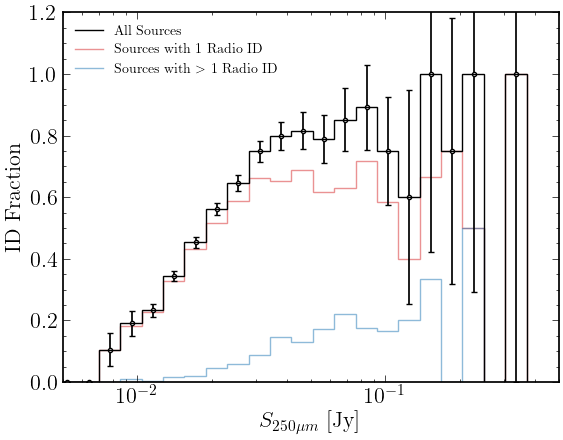

In [14]:
# Plot of the ID fraction as a function of 250-micron flux
fig, ax = plt.subplots()
ax.stairs(primaries_fluxes_id, flux_range, label=r'All Sources', zorder=10)
ax.errorbar(bin_centers, primaries_fluxes_id, yerr=primaries_fluxes_id_err, fmt='.', c='k')
ax.stairs(singles_fluxes_id, flux_range, color='tab:red', alpha=0.5, label=r'Sources with 1 Radio ID')
ax.stairs(multiples_fluxes_id, flux_range, color='tab:blue', alpha=0.5, label=r'Sources with $>$ 1 Radio ID')
ax.set_xlabel(r'$S_{250\mu m}$ [Jy]')
ax.set_ylabel(r'ID Fraction')
ax.set_xlim(5e-3,5e-1)
ax.set_ylim(0,1.2)
ax.semilogx()
ax.legend(loc='upper left', fontsize=10)
plt.savefig(utils.ROOT+'/figures/Figure_5_4.pdf', dpi=1000)
plt.show()

#### Determining Positional Errors

In [15]:
# Source-counterpart offsets
primaries_sc_offset = [pair.r for pair in herschel_vla_flux['primaries']]
secondaries_sc_offset = [pair.r for pair in herschel_vla_flux['secondaries']]
tertiaries_sc_offset = [pair.r for pair in herschel_vla_flux['tertiaries']]

# Primary redshifts
primaries_z = [pair.counterpart.redshift for pair in herschel_vla_flux['primaries']]
primaries_median_z = np.nanmedian(primaries_z)

# Average source-counterpart offsets
singles_sc_offset_average = [pair.r for pair in herschel_vla_flux['singles']]
multiples_sc_offset_average = [group.average_counterpart_source_separation for group in herschel_vla_flux['multiples']]
all_sc_offset_average = singles_sc_offset_average+multiples_sc_offset_average
all_sc_offset = primaries_sc_offset+secondaries_sc_offset+tertiaries_sc_offset

# Generating histograms of source-counterpart offsets
primaries_sc_offset_hist, r_bins = np.histogram(primaries_sc_offset, bins=20, range=(0,10))
primaries_sc_offset_hist_err = np.sqrt(primaries_sc_offset_hist)
all_average_sc_offset_hist, _ = np.histogram(all_sc_offset_average, bins=20, range=(0,10))
all_sc_offset_hist, _ = np.histogram(all_sc_offset, bins=20, range=(0,10))
r_bin_centers = (r_bins[:-1] + r_bins[1:])/2

In [16]:
# Create a model for our radial offset distribution
rmodel = Model(utils.rayleigh)
params = rmodel.make_params(A=500, sigma=2)
params['A'].vary = True
params['sigma'].vary = True
result = rmodel.fit(primaries_sc_offset_hist, params, r=r_bin_centers, weights=1/primaries_sc_offset_hist_err)

# Determine the best fitting values of parameters
A_best = result.params['A'].value
sigma_best = result.params['sigma'].value

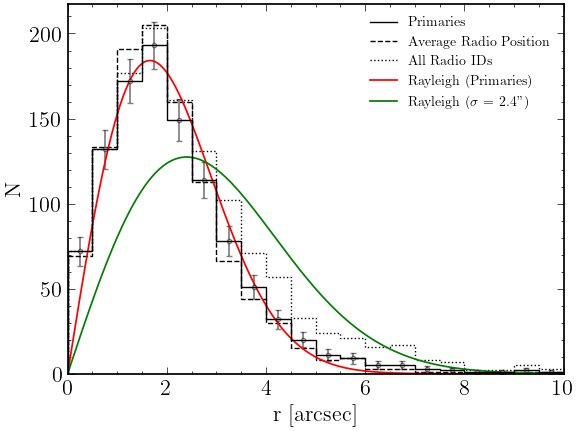

In [125]:
# Defining quantities for comparison with LR f(r)
sigma_lr = 2.4
r_range = np.linspace(0,10,1000)
d_range = np.linspace(0,80,1000)

# Plot of Rayleigh distributions
fig, ax = plt.subplots()
ax.stairs(primaries_sc_offset_hist, r_bins, label='Primaries', zorder=10)
ax.errorbar(r_bin_centers, primaries_sc_offset_hist, yerr=primaries_sc_offset_hist_err, fmt='.', c='k', alpha=0.5)
ax.stairs(all_average_sc_offset_hist, r_bins, color='k', linestyle='--',  label='Average Radio Position')
ax.stairs(all_sc_offset_hist, r_bins, color='k', linestyle=':',  label='All Radio IDs')
ax.plot(r_range, utils.rayleigh(r_range, A_best, sigma_best), c='r', label=r'Rayleigh (Primaries)')
ax.plot(r_range, utils.rayleigh(r_range, A_best, sigma_lr), c='g', label=r'Rayleigh ($\sigma$ = 2.4")')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.set_xlim(0,10)
ax.legend(fontsize=10)
plt.savefig(utils.ROOT+'/figures/Figure_5_5.pdf', dpi=1000)
plt.show()

In [124]:
# Best fitting value of the positional error
print('The width of the Rayleigh distribution = {:.2f}'.format(sigma_best))

The width of the Rayleigh distribution = 1.66


#### Multiple Systems - Fluxes

In [19]:
# Ordered fluxes for primaries, secondaries and tertiaries
flux_ordered = [group.counterpart_flux_sorted for group in herschel_vla['multiples']]
first_flux = [list_[0] for list_ in flux_ordered]
second_flux = [list_[1] for list_ in flux_ordered]
third_flux = [list_[2] for list_ in flux_ordered]

# Contribution of primaries, secondaries and tertiaries to total flux
flux_contributions = [group.counterpart_flux_contribution() for group in herschel_vla['multiples']]
first_contribution = [list_[0] for list_ in flux_contributions]
second_contribution = [list_[1] for list_ in flux_contributions]
third_contribution = [list_[2] for list_ in flux_contributions]
source_fluxes = [group.source.fluxes[0]*1000 for group in herschel_vla['multiples']]

# Determine bins of equal width
def create_equal_width_bins(x, n_bins):
    """
    Returns an array in N bins of equal number

    :param x: Array of input values
    :param n_bins: Number of bins created
    :return: Equally sized bins
    """
    split_array = np.array_split(np.sort(x), n_bins)
    equal_bins = [split_array[0][0]]+[split_array[it][-1] for it in range(n_bins)]
    return equal_bins

equal_width_bins = create_equal_width_bins(source_fluxes, 5)

# Determine the median (with errors) contribution in equal bin widths
first_contribution_average, bin_edges, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 50))
first_contribution_low, _, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 16))
first_contribution_high, _, _ = binned_statistic(source_fluxes, first_contribution, bins=equal_width_bins, statistic=lambda x: np.percentile(x, 84))

bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

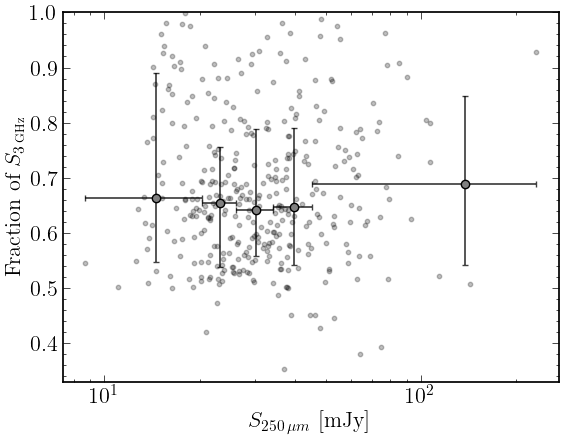

In [69]:
alpha = 0.75

# Plot of radio flux contribution from primaries, secondaries and tertiaries
fig, ax = plt.subplots()
ax.scatter(source_fluxes, first_contribution, alpha=0.25, s=10)
markers, caps, bars = ax.errorbar(bin_centers, first_contribution_average, xerr=(np.diff(bin_edges)/2), yerr=(first_contribution_average-first_contribution_low, first_contribution_high-first_contribution_average), mfc='grey', fmt='o')
[bar.set_alpha(alpha) for bar in bars]
[cap.set_alpha(alpha) for cap in caps]
ax.set_xlabel(r'$S_{\small 250\,\mu m}$ [mJy]')
ax.set_ylabel(r'Fraction of $S_{\small 3\,\textrm{GHz}}$')
ax.set_ylim(0.33, 1)
ax.semilogx()
plt.savefig(utils.ROOT+'/figures/Figure_5_6.pdf', dpi=1000)
plt.show()

#### Multiple Systems - Projected Separation and Redshifts

The median error on the redshift difference = 0.05


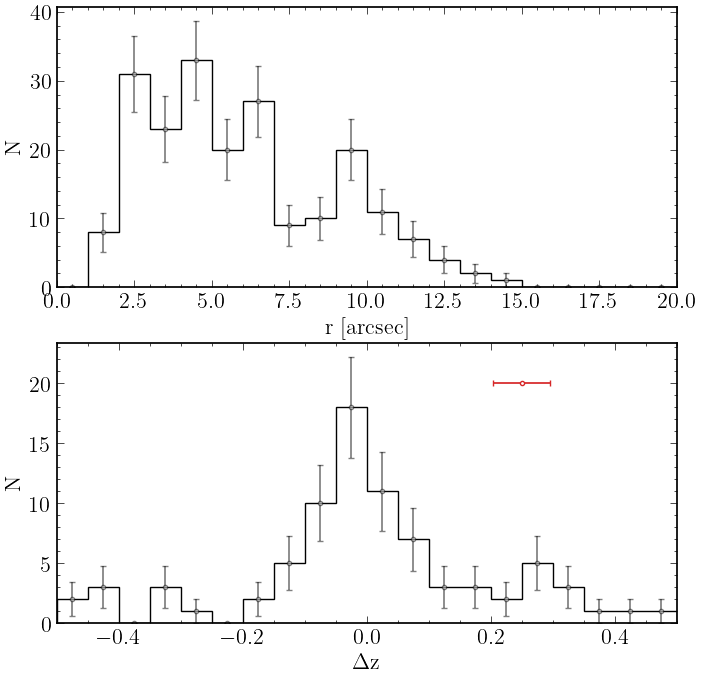

In [101]:
# Counterpart-counterpart offsets
multiples_cc_offsets = list(chain.from_iterable([obj.counterpart_counterpart_separations() for obj in herschel_vla_flux['multiples']]))
multiples_cc_offsets_hist, offsets_bins = np.histogram(multiples_cc_offsets, bins=20, range=(0,20))
offsets_bins_centers = (offsets_bins[:-1] + offsets_bins[1:])/2

# Counterpart-Counterpart redshift differences
multiples_cc_zdiff = list(chain.from_iterable([obj.counterpart_counterpart_z_difference_new()[0] for obj in herschel_vla_flux['multiples']]))
multiples_cc_zdiff_err = list(chain.from_iterable([obj.counterpart_counterpart_z_difference()[1] for obj in herschel_vla_flux['multiples']]))
multiples_cc_zdiff_hist, z_bins = np.histogram(multiples_cc_zdiff, bins=20, range=(-0.5,0.5))
z_bins_centers = (z_bins[:-1] + z_bins[1:])/2
median_diffz = np.nanmedian(multiples_cc_zdiff_err)
print('The median error on the redshift difference = {:.2f}'.format(median_diffz))

# Plot of the counterpart-counterpart separations and redshift differences
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.stairs(multiples_cc_offsets_hist, offsets_bins)
ax1.errorbar(offsets_bins_centers, multiples_cc_offsets_hist, yerr=np.sqrt(multiples_cc_offsets_hist), fmt='.', c='k', alpha=0.5)
ax1.set_xlabel(r'r [arcsec]')
ax1.set_ylabel(r'N')
ax1.set_xlim(0,20)
ax2.stairs(multiples_cc_zdiff_hist, z_bins)
ax2.errorbar(z_bins_centers, multiples_cc_zdiff_hist, yerr=np.sqrt(multiples_cc_zdiff_hist), fmt='.', c='k', alpha=0.5)
ax2.errorbar(0.25, 20, xerr=median_diffz, fmt='.', color='tab:red')
ax2.set_xlabel(r'$\Delta$z')
ax2.set_ylabel(r'N')
ax2.set_xlim(-0.5,0.5)
plt.savefig(utils.ROOT+'/figures/Figure_5_7.pdf', dpi=1000)
plt.show()

In [60]:
# Calculating the fraction of sources with multiple IDs that are within 0.1 in redshift
z_diff_finite = [z_diff for z_diff in list(chain.from_iterable([obj.counterpart_counterpart_z_difference()[0] for obj in herschel_vla_flux['multiples']])) if np.isfinite(z_diff)]
z_diff_finite_small = [z_diff for z_diff in z_diff_finite if z_diff < 0.1]
print('The fraction of multiples where the difference in redshifts is < 0.1 = {:.2f}'.format((len(z_diff_finite_small)/len(z_diff_finite))*100))

The fraction of multiples where the difference in redshifts is < 0.1 = 32.17


#### Missing IDs

In [28]:
# The number of sources without secure IDs
n_blanks_or_nonsig = len(herschel_vla_flux['blanks'])
percentage_blanks_or_nonsig = (n_blanks_or_nonsig/n_sources_flux)*100
print('The number of sources with no IDs (or non-significant associations) = {} ({:.2f}%)'.format(n_blanks_or_nonsig, percentage_blanks_or_nonsig))

The number of sources with no IDs (or non-significant associations) = 271 (20.47%)


In [29]:
def colour(wave_obs_um_1, wave_obs_um_2, z, t, beta):
    """
    Returns the colour from a given SED
    
    :param wave_obs_um_1: First observed wavelength [microns]
    :param wave_obs_um_2: Second observed wavelength [microns]
    :param z: Redshift
    :param t: Dust temperature [K]
    :param beta: Dust emissivity spectral index
    :return: 
    """

    # Convert observed wavelengths to rest frame frequencies.
    wave_obs_m_1, wave_obs_m_2 = wave_obs_um_1*1e-6, wave_obs_um_2*1e-6
    wave_rest_m_1, wave_rest_m_2 = wave_obs_m_1/(1+z), wave_obs_m_2/(1+z)
    nu_rest_1, nu_rest_2 = c.value/wave_rest_m_1, c.value/wave_rest_m_2

    # Calculate colour from SED
    colour = utils.mbb(nu_rest_1, 1, t, beta)/utils.mbb(nu_rest_2, 1, t, beta)
    return colour

# Colours of blanks sources
blanks_250_350 = [blank.fluxes[0]/blank.fluxes[1] for blank in herschel_vla_flux['blanks']]
blanks_500_350 = [blank.fluxes[2]/blank.fluxes[1] for blank in herschel_vla_flux['blanks']]

# Colours of primary IDs
primaries_250_350 = [obj.source.fluxes[0]/obj.source.fluxes[1] for obj in herschel_vla_flux['primaries']]
primaries_500_350 = [obj.source.fluxes[2]/obj.source.fluxes[1] for obj in herschel_vla_flux['primaries']]

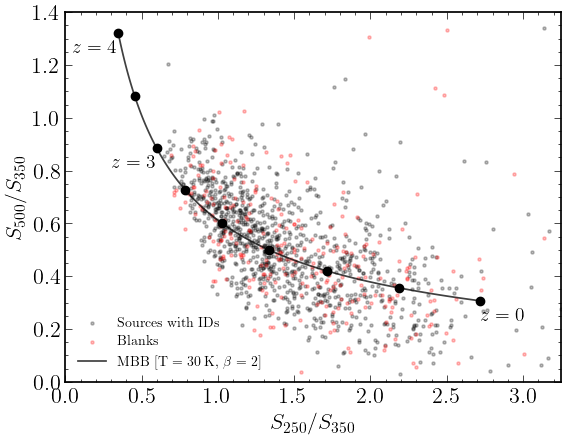

In [66]:
z_range = np.linspace(0,4,100)

# Plot of far-IR colours of blanks and primary IDs
fig, ax = plt.subplots()
ax.scatter(primaries_250_350, primaries_500_350, alpha=0.25, s=5, label=r'Sources with IDs')
ax.scatter(blanks_250_350, blanks_500_350, alpha=0.25, s=5, label='Blanks')
ax.plot(colour(250, 350, z_range, 30, 2), colour(500, 350, z_range, 30, 2), alpha=0.75, label=r'MBB [T = 30\,K, $\beta$ = 2]')
ax.text(colour(250, 350, 0, 30, 2), colour(500, 350, 0, 30, 2)-0.075, r'$z = 0$', fontsize=14)
#ax.text(colour(250, 350, 1, 30, 2)-0.15, colour(500, 350, 1, 30, 2)-0.075, r'$z = 1$', fontsize=9)
#ax.text(colour(250, 350, 2, 30, 2)-0.25, colour(500, 350, 2, 30, 2)-0.05, r'$z = 2$', fontsize=9)
ax.text(colour(250, 350, 3, 30, 2)-0.3, colour(500, 350, 3, 30, 2)-0.075, r'$z = 3$', fontsize=14)
ax.text(colour(250, 350, 4, 30, 2)-0.3, colour(500, 350, 4, 30, 2)-0.075, r'$z = 4$', fontsize=14)
ax.scatter(colour(250, 350, np.array([0,0.5,1,1.5,2,2.5,3,3.5,4]), 30, 2), colour(500, 350, np.array([0,0.5,1,1.5,2,2.5,3,3.5,4]), 30, 2), c='k')
ax.set_xlabel(r'$S_{250}/S_{350}$')
ax.set_ylabel(r'$S_{500}/S_{350}$')
ax.set_xlim(0,3.25)
ax.set_ylim(0,1.4)
ax.legend(fontsize=10, loc='lower left', markerscale=1)
plt.savefig(utils.ROOT+'/figures/Figure_5_8.pdf', dpi=1000)
plt.show()

In [31]:
# The effects of increasing the maximum P to 0.1 to find missing IDs
_, herschel_vla_p01 = cosmos.get_groups(r_max_arcsec=r_max, p_max=0.1, n=100000)
herschel_vla_flux_p01 = utils.apply_flux_limit(herschel_vla_p01, flux_limit)
print('Number of blank sources if we allow P < 0.1 = {} (Down by {})'.format(len(herschel_vla_flux_p01['blanks']), len(herschel_vla_flux['blanks']) - len(herschel_vla_flux_p01['blanks'])))

Calculating P Values: 100%|██████████| 7230/7230 [00:46<00:00, 154.07it/s]


Number of blank sources if we allow P < 0.1 = 254 (Down by 17)


---

### The Star Forming Main Sequence

In [32]:
def scoville_ms(m_star, z):
    """
    Returns the Scoville et al., 2017 main sequence of star formation
    
    :param m_star: Stellar mass [Msun]
    :param z: Redshift
    :return: Star forming main sequence
    """
    logm_star = np.log10(m_star)
    a = (10**(logm_star-10.31))**(-1.07)
    b = np.log10(1+a)
    norm = 3.23/(10**1.50883)
    ms = norm*((1+z)**2.9)*(10**(1.72-b))
    return ms

def sfr_to_ssfr(m_star, sfr):
    """
    Translates SFR to sSFR
    
    :param m_star: Stellar mass [Msun]
    :param sfr: Star formation rate [Msun yr-1]
    :return: Specific star formation rate [yr-1]
    """
    sfr = sfr*(u.M_sun/u.yr)
    ssfr = sfr/(m_star*u.M_sun)
    return ssfr.to(1/u.Gyr)

def ssfr_to_sfr(m_star, ssfr):
    """
    Translates sSFR to SFR
    
    :param m_star: Stellar mass [Msun]
    :param ssfr: Specific star formation rate [yr-1]
    :return: Star formation rate [Msun yr-1]
    """
    ssfr = ssfr*(1/u.Gyr)
    sfr = ssfr*(m_star*u.M_sun)
    return sfr.to(u.M_sun/u.yr)

def scoville_ssfr(m_star, z):
    """
    Returns the Scoville et al., 2017 main sequence of star formation in terms of sSFR
    
    :param m_star: Stellar mass [Msun]
    :param z: Redshift
    :return: Star forming main sequence in sSFR
    """
    sfr = scoville_ms(m_star,z)
    return sfr_to_ssfr(m_star, sfr)

In [33]:
# Locate all primary IDs and obtain their LIRs, redshifts, SFRs, stellar masses, ages and sSFRs
pairs = [pair for pair in herschel_vla_flux['primaries'] if ~np.isnan(pair.counterpart.stellar_mass) & (9 < pair.counterpart.stellar_mass < 12) & (0.1 < pair.sfr().value < 5000)]
lirs = np.array([pair.ir_luminosity().value for pair in pairs])
redshifts = np.array([pair.counterpart.redshift for pair in pairs])
sfrs = np.array([pair.sfr().value for pair in pairs])
masses = np.array([10**pair.counterpart.stellar_mass for pair in pairs])
ages_yr = np.array([pair.counterpart.age for pair in pairs])
ssfrs = sfr_to_ssfr(masses, sfrs)
ages_gyr = (ages_yr/1e9)*u.Gyr

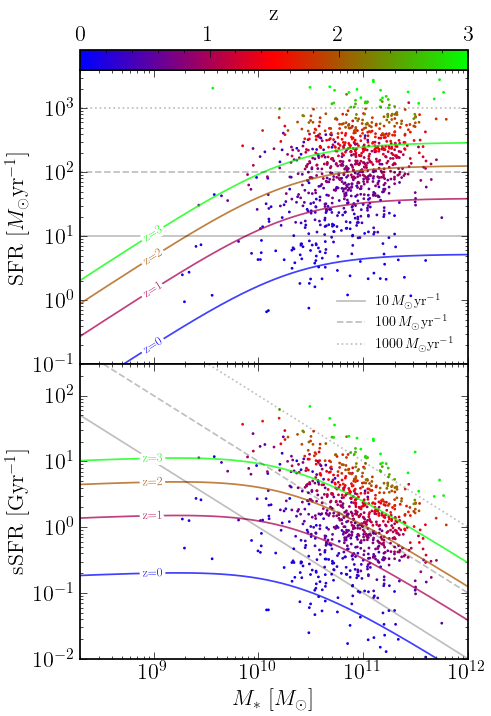

In [34]:
# Create a unique colour scale for plotting
m_range = np.logspace(8,15,1000)
c_norm = mpl.colors.Normalize(vmin=0, vmax=3)
c_map  = mpl.cm.brg
s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])

# Plot of our sources with respect to the star forming main sequence
fig, axes = plt.subplots(2,1,figsize=(5,9), sharex=True)

ax1, ax2 = axes

sc = ax1.scatter(masses, sfrs, s=1, c=redshifts, cmap=c_map, vmin=0, vmax=3)
ax1.plot(m_range, scoville_ms(m_range,0), c=s_map.to_rgba(0), alpha=0.75, label=r'z=0')
ax1.plot(m_range, scoville_ms(m_range,1), c=s_map.to_rgba(1), alpha=0.75, label=r'z=1')
ax1.plot(m_range, scoville_ms(m_range,2), c=s_map.to_rgba(2), alpha=0.75, label=r'z=2')
ax1.plot(m_range, scoville_ms(m_range,3), c=s_map.to_rgba(3), alpha=0.75, label=r'z=3')
line_10 = ax1.plot(m_range, np.full_like(m_range, 10), c='k', linestyle='-', alpha=0.25, label=r'$10\,M_{\odot}$yr$^{-1}$')
line_100 = ax1.plot(m_range, np.full_like(m_range, 100), c='k', linestyle='--', alpha=0.25, label=r'$100\,M_{\odot}$yr$^{-1}$')
line_1000 = ax1.plot(m_range, np.full_like(m_range, 1000), c='k', linestyle=':', alpha=0.25, label=r'$1000\,M_{\odot}$yr$^{-1}$')

ax1.set_ylim(0.1,4000)
ax1.set_ylabel(r'SFR [$M_{\odot}$yr$^{-1}$]')
ax1.loglog()
ax1.legend(handles=[line_10[0], line_100[0], line_1000[0]], fontsize=10)
labelLines(ax1.get_lines(), fontsize=9, xvals=[1e9,1e9,1e9,1e9])

sc = ax2.scatter(masses, ssfrs, s=1, c=redshifts, cmap=c_map, vmin=0, vmax=3)
ax2.plot(m_range, scoville_ssfr(m_range,0), c=s_map.to_rgba(0), alpha=0.75, label=r'z=0')
ax2.plot(m_range, scoville_ssfr(m_range,1), c=s_map.to_rgba(1), alpha=0.75, label=r'z=1')
ax2.plot(m_range, scoville_ssfr(m_range,2), c=s_map.to_rgba(2), alpha=0.75, label=r'z=2')
ax2.plot(m_range, scoville_ssfr(m_range,3), c=s_map.to_rgba(3), alpha=0.75, label=r'z=3')
line_10 = ax2.plot(m_range, sfr_to_ssfr(m_range, 10), c='k', linestyle='-', alpha=0.25, label=r'$10\,M_{\odot}$yr$^{-1}$')
line_100 = ax2.plot(m_range, sfr_to_ssfr(m_range, 100), c='k', linestyle='--', alpha=0.25, label=r'$100\,M_{\odot}$yr$^{-1}$')
line_1000 = ax2.plot(m_range, sfr_to_ssfr(m_range, 1000), c='k', linestyle=':', alpha=0.25, label=r'$1000\,M_{\odot}$yr$^{-1}$')

ax2.set_xlim(2e8,1e12)
ax2.set_ylim(1e-2,3e2)
ax2.set_xlabel(r'$M_{*}$ [$M_{\odot}$]')
ax2.set_ylabel(r'sSFR [Gyr$^{-1}$]')
ax2.loglog()
labelLines(ax2.get_lines(), fontsize=9, xvals=[1e9,1e9,1e9,1e9])

plt.subplots_adjust(hspace=0)
plt.colorbar(sc, label='z', ax=axes.ravel().tolist(), location='top', pad=0)
plt.savefig(utils.ROOT+'/figures/Figure_5_9.pdf', dpi=1000)
plt.show()

In [35]:
# Determine redshifts and LIRs of sources with high SFR
z_high_sfr = [z for sfr,z,lir in zip(sfrs, redshifts, lirs) if sfr > 1000]
lir_high_sfr = [np.log10(lir) for sfr,z,lir in zip(sfrs, redshifts, lirs) if sfr > 1000]
print('The lowest IR luminosity for sources with SFR > 1,000 Msun/yr = {:.1f}'.format(min(lir_high_sfr)))

The lowest IR luminosity for sources with SFR > 1,000 Msun/yr = 12.8


In [36]:
# Define the doubling timescales and age of Universe at each source
taus = [1/ssfr for ssfr in ssfrs]
universe_ages = [cosmo.age(z) for z in redshifts]
fraction_of_age = [tau/age for tau,age in zip(taus, universe_ages)]

def split_by_redshifts(z1, z2, quantity):
    """
    Function to split a list by redshift
    
    :param z1: Lower redshift limit
    :param z2: Upper redshift limit
    :param quantity: Quantity to be split by redshift
    :return: List of quantity within redshift bounds 
    """
    quantity_split = [q for z,q in zip(redshifts, quantity) if z1 < z < z2]
    return quantity_split

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/786828328.py:14: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 3
  ax.legend(handles=[empty]*len(labels), labels=['$0 < z < 1$', '$1 < z < 2$', '$2 < z < 3$'], markerscale=0,fontsize=10, labelcolor=[s_map.to_rgba(0.5), s_map.to_rgba(1.5), s_map.to_rgba(2.5)])


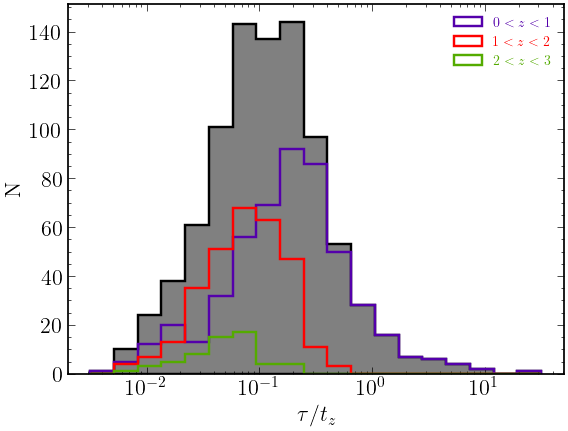

In [67]:
# Plot of doubling timescales by redshift
fig, ax = plt.subplots()
ax.hist(fraction_of_age, bins=np.logspace(-2.5,1.5,20), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey')
ax.hist(split_by_redshifts(0,1,fraction_of_age), bins=np.logspace(-2.5,1.5,20), histtype='step', linewidth=1.75, ec=s_map.to_rgba(0.5), label=r'$0 < z < 1$')
ax.hist(split_by_redshifts(1,2,fraction_of_age), bins=np.logspace(-2.5,1.5,20), histtype='step', linewidth=1.75, ec=s_map.to_rgba(1.5), label=r'$1 < z < 2$')
ax.hist(split_by_redshifts(2,3,fraction_of_age), bins=np.logspace(-2.5,1.5,20), histtype='step', linewidth=1.75, ec=s_map.to_rgba(2.5), label=r'$2 < z < 3$')

empty = mpl.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False)
handles, labels = ax2.get_legend_handles_labels()

ax.set_xlabel(r'$\tau/t_z$')
ax.set_ylabel(r'N')
ax.semilogx()
ax.legend(handles=[empty]*len(labels), labels=['$0 < z < 1$', '$1 < z < 2$', '$2 < z < 3$'], markerscale=0,fontsize=10, labelcolor=[s_map.to_rgba(0.5), s_map.to_rgba(1.5), s_map.to_rgba(2.5)])
plt.savefig(utils.ROOT+'/figures/Figure_5_10.pdf', dpi=1000)
plt.show()

---

### Differentiating DSFGs and non-DSFGs

In [38]:
# Obtain IDs, offsets and P values for primaries
primary_source_ids = [pair.source.id for pair in herschel_vla_flux['primaries']]
primary_counterpart_ids = [pair.counterpart.id for pair in herschel_vla_flux['primaries']]
primary_r_values = [pair.r for pair in herschel_vla_flux['primaries']]
primary_p_values = [pair.p for pair in herschel_vla_flux['primaries']]

primary_df = []

# Create a data frame for each source and counterpart
for id, source_id, counterpart_id in zip(range(len(primary_source_ids)), primary_source_ids, primary_counterpart_ids):
    source_obj = herschel.loc[herschel['id_her'] == source_id]
    source_obj.reset_index(drop=True, inplace=True)
    counterpart_obj = vla.loc[vla['id_cos'] == counterpart_id]
    counterpart_obj.reset_index(drop=True, inplace=True)
    r_val = primary_r_values[id]
    p_val = primary_p_values[id]
    new_df = pd.concat([source_obj, counterpart_obj], axis=1)
    new_df['r_value'] = r_val
    new_df['P_value'] = p_val
    primary_df.append(new_df)

# Create a complete data frame for all primaries
primary_smgs = pd.concat(primary_df, ignore_index=True)
primary_smgs.to_csv(utils.ROOT+'/data/primaries.csv')

# Randomly assign an offset to objects in COSMOS in line with a radial distribution
r = [r_max*np.sqrt(np.random.rand()) for _ in range(len(cosmos2020))]
cosmos2020['r_value'] = r

In [39]:
# Printing the number of primary objects observed at each wavelength in COSMOS2020
def print_coverage(bands):
    for band in bands:
        n = sum(~np.isnan(primary_smgs[band]))
        percent = (sum(~np.isnan(primary_smgs[band]))/len(primary_smgs))*100
        print('Coverage from {} for {} sources ({:.2f}%)'.format(band, n, percent))

print_coverage(['CFHT_u_MAG_AUTO', 'HSC_g_MAG_AUTO', 'HSC_r_MAG_AUTO', 'HSC_i_MAG_AUTO','HSC_z_MAG_AUTO', 'HSC_y_MAG_AUTO', 'UVISTA_Y_MAG_AUTO', 'UVISTA_J_MAG_AUTO', 'UVISTA_H_MAG_AUTO', 'UVISTA_Ks_MAG_AUTO', 'SC_IB427_MAG_AUTO', 'SC_IB464_MAG_AUTO', 'SC_IA484_MAG_AUTO', 'SC_IB505_MAG_AUTO', 'SC_IA527_MAG_AUTO', 'SC_IB574_MAG_AUTO', 'SC_IA624_MAG_AUTO', 'SC_IA679_MAG_AUTO', 'SC_IB709_MAG_AUTO', 'SC_NB711_MAG_AUTO', 'SC_IA738_MAG_AUTO', 'SC_IA767_MAG_AUTO', 'SC_NB816_MAG_AUTO', 'SC_IB827_MAG_AUTO', 'UVISTA_NB118_MAG_AUTO', 'SC_B_MAG_AUTO', 'SC_gp_MAG_AUTO', 'SC_V_MAG_AUTO', 'SC_rp_MAG_AUTO', 'SC_ip_MAG_AUTO', 'SC_zp_MAG_AUTO', 'SC_zpp_MAG_AUTO', 'GALEX_FUV_MAG', 'GALEX_NUV_MAG', 'SPLASH_CH1_MAG', 'SPLASH_CH2_MAG', 'SPLASH_CH3_MAG', 'SPLASH_CH4_MAG', 'ACS_F814W_MAG'])

Coverage from CFHT_u_MAG_AUTO for 848 sources (80.53%)
Coverage from HSC_g_MAG_AUTO for 920 sources (87.37%)
Coverage from HSC_r_MAG_AUTO for 921 sources (87.46%)
Coverage from HSC_i_MAG_AUTO for 923 sources (87.65%)
Coverage from HSC_z_MAG_AUTO for 923 sources (87.65%)
Coverage from HSC_y_MAG_AUTO for 923 sources (87.65%)
Coverage from UVISTA_Y_MAG_AUTO for 738 sources (70.09%)
Coverage from UVISTA_J_MAG_AUTO for 735 sources (69.80%)
Coverage from UVISTA_H_MAG_AUTO for 740 sources (70.28%)
Coverage from UVISTA_Ks_MAG_AUTO for 740 sources (70.28%)
Coverage from SC_IB427_MAG_AUTO for 805 sources (76.45%)
Coverage from SC_IB464_MAG_AUTO for 792 sources (75.21%)
Coverage from SC_IA484_MAG_AUTO for 844 sources (80.15%)
Coverage from SC_IB505_MAG_AUTO for 837 sources (79.49%)
Coverage from SC_IA527_MAG_AUTO for 835 sources (79.30%)
Coverage from SC_IB574_MAG_AUTO for 837 sources (79.49%)
Coverage from SC_IA624_MAG_AUTO for 861 sources (81.77%)
Coverage from SC_IA679_MAG_AUTO for 849 sources

In [40]:
# Defining the set of bands that will be used for plotting 
bands_for_use = ['GALEX_NUV_MAG', 'CFHT_u_MAG_AUTO', 'HSC_g_MAG_AUTO', 'HSC_r_MAG_AUTO', 'HSC_i_MAG_AUTO', 'ACS_F814W_MAG', 'HSC_z_MAG_AUTO', 'HSC_y_MAG_AUTO', 'UVISTA_Y_MAG_AUTO', 'UVISTA_J_MAG_AUTO', 'UVISTA_H_MAG_AUTO', 'UVISTA_Ks_MAG_AUTO', 'SPLASH_CH1_MAG', 'SPLASH_CH2_MAG', 'SPLASH_CH3_MAG', 'SPLASH_CH4_MAG', 'lp_zPDF', 'lp_mass_med', 'r_value']

# Restricting primaries and COSMOS2020 to plotting bands
primary_smg_bands = primary_smgs[bands_for_use]
cosmos2020_bands = cosmos2020[bands_for_use]

In [41]:
def make_colour_plot(xband1, xband2, yband1, yband2, n=10000, xlabel=None, ylabel=None, xrange=None, yrange=None, ax=ax, fontsize=12):
    """
    Creates a colour-colour plot comparing the COSMOS2020 field with primary IDs

    :param xband1: First x-axis wavelength
    :param xband2: Second x-axis wavelength
    :param yband1: First y-axis wavelength
    :param yband2: Second y-axis wavelength
    :param n: Number of background objects for histogram (Default = 10,000)
    :param xlabel: Label of x-axis (Default = None)
    :param ylabel: Label of y-axis (Default = None)
    :param xrange: Range of x-axis (Default = None)
    :param yrange: Range of y-axis (Default = None)
    :param ax: Axis object (Default = "ax")
    :param fontsize: Font size (Default = 12)
    :return: Scatter plot object
    """

    smg_colourx = primary_smg_bands[xband1] - primary_smg_bands[xband2]
    smg_coloury = primary_smg_bands[yband1] - primary_smg_bands[yband2]

    random_sources = cosmos2020_bands.iloc[np.random.randint(0,len(cosmos2020_bands),n)]
    random_colourx = random_sources[xband1] - random_sources[xband2]
    random_coloury = random_sources[yband1] - random_sources[yband2]

    ax.hist2d(random_colourx, random_coloury, bins=40, range=[[xrange[0], xrange[1]],[yrange[0], yrange[1]]], cmap=blacks)
    sc = ax.scatter(smg_colourx, smg_coloury, c=primary_smgs['lp_zPDF'], vmin=0, vmax=3, cmap=c_map, s=5)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize)
    if xrange:
        ax.set_xlim(xrange[0],xrange[1])
    if yrange:
        ax.set_ylim(yrange[0],yrange[1])

    return sc

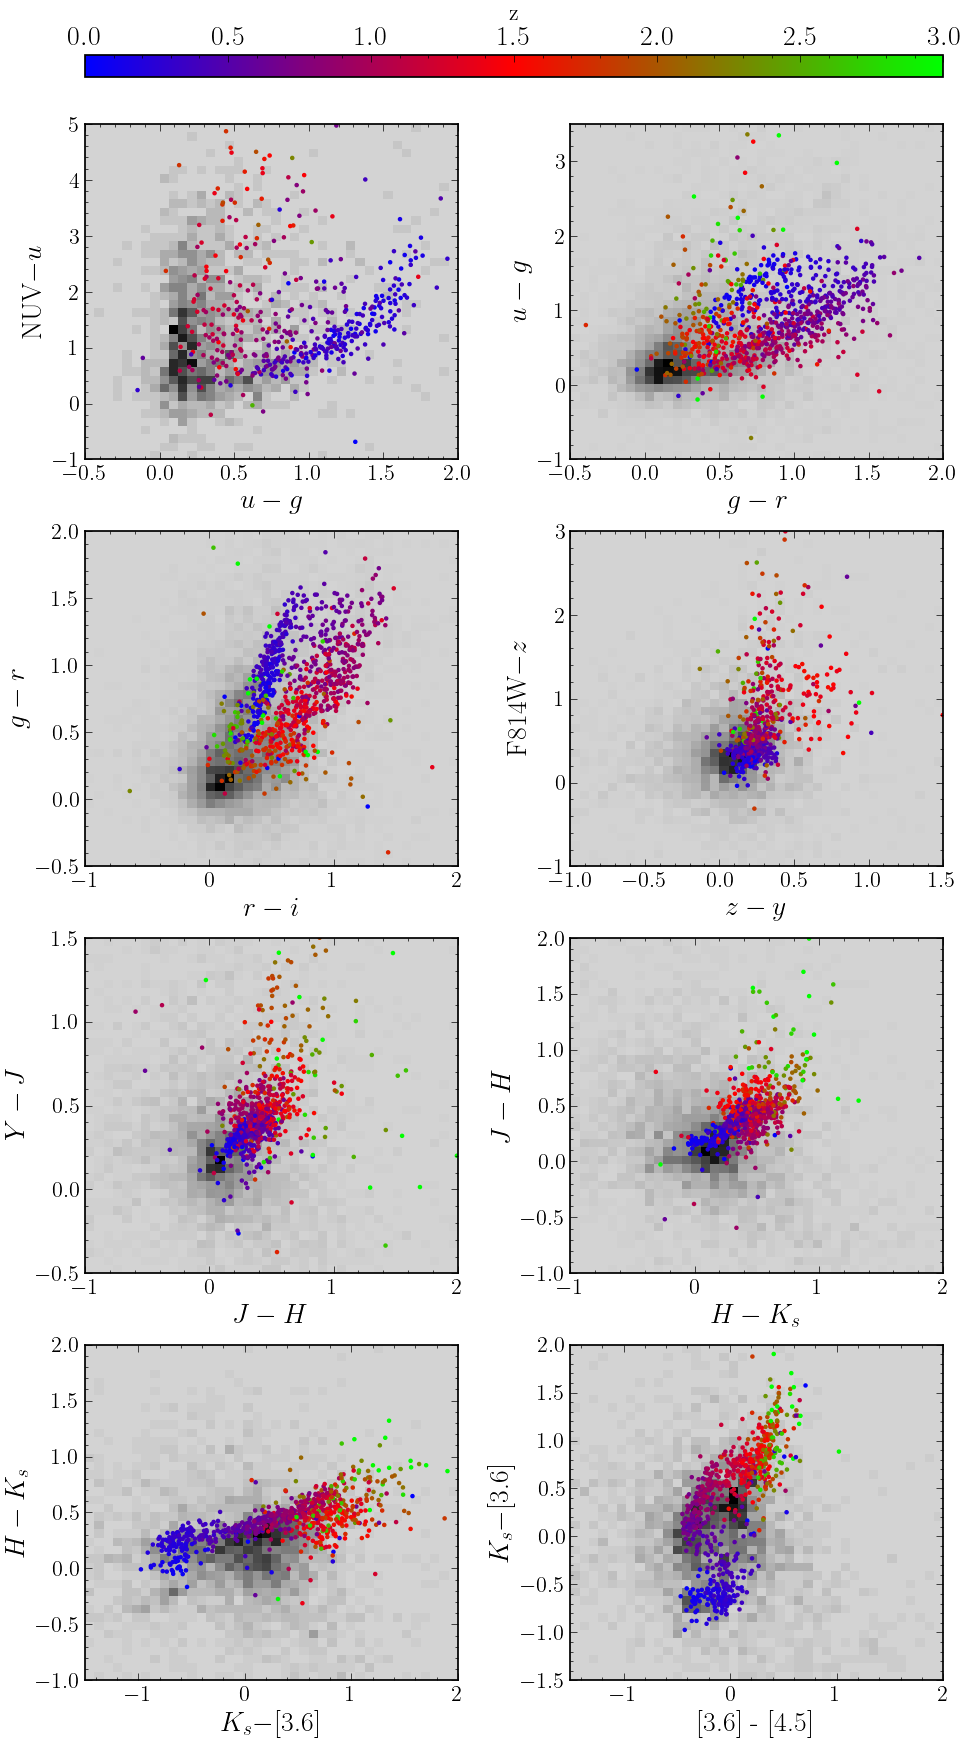

In [42]:
# Set a new colour map for background histogram
colors_black = [mc.to_rgba("lightgrey"), mc.to_rgba("black")]
blacks = LinearSegmentedColormap.from_list("Custom", colors_black, N=256)

# Plot of a range of colour-colour spaces for primaries compared to all COSMOS2020 
fig, axes = plt.subplots(4,2,figsize=(10,20))
((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = axes
make_colour_plot(xband1='CFHT_u_MAG_AUTO', xband2='HSC_g_MAG_AUTO', yband1='GALEX_NUV_MAG', yband2='CFHT_u_MAG_AUTO',xrange=(-0.5,2), yrange=(-1,5), xlabel=r'$u - g$', ylabel=r'NUV$ - u$', ax=ax1, fontsize=20)
make_colour_plot(xband1='HSC_g_MAG_AUTO', xband2='HSC_r_MAG_AUTO', yband1='CFHT_u_MAG_AUTO', yband2='HSC_g_MAG_AUTO', xrange=(-0.5,2), yrange=(-1,3.5), xlabel=r'$g - r$', ylabel=r'$u - g$', ax=ax2, fontsize=20)
make_colour_plot(xband1='HSC_r_MAG_AUTO', xband2='HSC_i_MAG_AUTO', yband1='HSC_g_MAG_AUTO', yband2='HSC_r_MAG_AUTO', xrange=(-1,2), yrange=(-0.5,2), xlabel=r'$r - i$', ylabel=r'$g - r$', ax=ax3, fontsize=20)
make_colour_plot(xband1='HSC_z_MAG_AUTO', xband2='HSC_y_MAG_AUTO', yband1='ACS_F814W_MAG', yband2='HSC_z_MAG_AUTO', xrange=(-1,1.5), yrange=(-1,3), xlabel=r'$z - y$', ylabel=r'F814W$ - z$', ax=ax4, fontsize=20)
make_colour_plot(xband1='UVISTA_J_MAG_AUTO', xband2='UVISTA_H_MAG_AUTO', yband1='UVISTA_Y_MAG_AUTO', yband2='UVISTA_J_MAG_AUTO', xrange=(-1,2), yrange=(-0.5,1.5), xlabel=r'$J - H$', ylabel=r'$Y - J$', ax=ax5, fontsize=20)
make_colour_plot(xband1='UVISTA_H_MAG_AUTO', xband2='UVISTA_Ks_MAG_AUTO', yband1='UVISTA_J_MAG_AUTO', yband2='UVISTA_H_MAG_AUTO', xrange=(-1,2), yrange=(-1,2), xlabel=r'$H - K_s$', ylabel=r'$J - H$', ax=ax6, fontsize=20)
make_colour_plot(xband1='UVISTA_Ks_MAG_AUTO', xband2='SPLASH_CH1_MAG', yband1='UVISTA_H_MAG_AUTO', yband2='UVISTA_Ks_MAG_AUTO', xrange=(-1.5,2), yrange=(-1,2), xlabel=r'$K_s - $[3.6]', ylabel=r'$H - K_s$', ax=ax7, fontsize=20)
sc = make_colour_plot(xband1='SPLASH_CH1_MAG', xband2='SPLASH_CH2_MAG', yband1='UVISTA_Ks_MAG_AUTO', yband2='SPLASH_CH1_MAG', xrange=(-1.5,2), yrange=(-1.5,2), xlabel=r'[3.6] - [4.5]', ylabel=r'$K_s - $[3.6]', ax=ax8, fontsize=20)
plt.tight_layout()
cbar = plt.colorbar(sc, label='z', ax=axes.ravel().tolist(), location='top', aspect=40, pad=0.025)
cbar.ax.tick_params(labelsize=20)
plt.savefig(utils.ROOT+'/figures/Figure_5_11.pdf', dpi=1000)
plt.show()

In [43]:
# Create all colours for primary IDs
primary_smg_bands['NUV_u'] = primary_smg_bands['GALEX_NUV_MAG']-primary_smg_bands['CFHT_u_MAG_AUTO']
primary_smg_bands['u_g'] = primary_smg_bands['CFHT_u_MAG_AUTO']-primary_smg_bands['HSC_g_MAG_AUTO']
primary_smg_bands['g_r'] = primary_smg_bands['HSC_g_MAG_AUTO']-primary_smg_bands['HSC_r_MAG_AUTO']
primary_smg_bands['r_i'] = primary_smg_bands['HSC_r_MAG_AUTO']-primary_smg_bands['HSC_i_MAG_AUTO']
primary_smg_bands['i_F814W'] = primary_smg_bands['HSC_i_MAG_AUTO']-primary_smg_bands['ACS_F814W_MAG']
primary_smg_bands['F814W_z'] = primary_smg_bands['ACS_F814W_MAG']-primary_smg_bands['HSC_z_MAG_AUTO']
primary_smg_bands['z_y'] = primary_smg_bands['HSC_z_MAG_AUTO']-primary_smg_bands['HSC_y_MAG_AUTO']
primary_smg_bands['Y_J'] = primary_smg_bands['UVISTA_Y_MAG_AUTO']-primary_smg_bands['UVISTA_J_MAG_AUTO']
primary_smg_bands['J_H'] = primary_smg_bands['UVISTA_J_MAG_AUTO']-primary_smg_bands['UVISTA_H_MAG_AUTO']
primary_smg_bands['H_Ks'] = primary_smg_bands['UVISTA_H_MAG_AUTO']-primary_smg_bands['UVISTA_Ks_MAG_AUTO']
primary_smg_bands['Ks_36'] = primary_smg_bands['UVISTA_Ks_MAG_AUTO']-primary_smg_bands['SPLASH_CH1_MAG']
primary_smg_bands['36_45'] = primary_smg_bands['SPLASH_CH1_MAG']-primary_smg_bands['SPLASH_CH2_MAG']

# Create all colours for COSMOS2020
cosmos2020_bands['NUV_u'] = cosmos2020_bands['GALEX_NUV_MAG']-cosmos2020_bands['CFHT_u_MAG_AUTO']
cosmos2020_bands['u_g'] = cosmos2020_bands['CFHT_u_MAG_AUTO']-cosmos2020_bands['HSC_g_MAG_AUTO']
cosmos2020_bands['g_r'] = cosmos2020_bands['HSC_g_MAG_AUTO']-cosmos2020_bands['HSC_r_MAG_AUTO']
cosmos2020_bands['r_i'] = cosmos2020_bands['HSC_r_MAG_AUTO']-cosmos2020_bands['HSC_i_MAG_AUTO']
cosmos2020_bands['i_F814W'] = cosmos2020_bands['HSC_i_MAG_AUTO']-cosmos2020_bands['ACS_F814W_MAG']
cosmos2020_bands['F814W_z'] = cosmos2020_bands['ACS_F814W_MAG']-cosmos2020_bands['HSC_z_MAG_AUTO']
cosmos2020_bands['z_y'] = cosmos2020_bands['HSC_z_MAG_AUTO']-cosmos2020_bands['HSC_y_MAG_AUTO']
cosmos2020_bands['Y_J'] = cosmos2020_bands['UVISTA_Y_MAG_AUTO']-cosmos2020_bands['UVISTA_J_MAG_AUTO']
cosmos2020_bands['J_H'] = cosmos2020_bands['UVISTA_J_MAG_AUTO']-cosmos2020_bands['UVISTA_H_MAG_AUTO']
cosmos2020_bands['H_Ks'] = cosmos2020_bands['UVISTA_H_MAG_AUTO']-cosmos2020_bands['UVISTA_Ks_MAG_AUTO']
cosmos2020_bands['Ks_36'] = cosmos2020_bands['UVISTA_Ks_MAG_AUTO']-cosmos2020_bands['SPLASH_CH1_MAG']
cosmos2020_bands['36_45'] = cosmos2020_bands['SPLASH_CH1_MAG']-cosmos2020_bands['SPLASH_CH2_MAG']

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/332793360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_smg_bands['NUV_u'] = primary_smg_bands['GALEX_NUV_MAG']-primary_smg_bands['CFHT_u_MAG_AUTO']
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/332793360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_smg_bands['u_g'] = primary_smg_bands['CFHT_u_MAG_AUTO']-primary_smg_bands['HSC_g_MAG_AUTO']
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_

In [44]:
def sigmoid(x, L, k, x0):
    """
    Returns a sigmoid function
    
    :param x: Variable parameter
    :param L: Normalization factor
    :param k: Exponential normalization factor
    :param x0: Offset in x
    :return: Sigmoid function
    """
    return (L/(1+np.exp(k*(x-x0))))


def smg_frac(band, band_name, mag_min, mag_max, figure_name=None, background_colour='w', n_error_bars=10):
    """
    Creates a plot for the fraction of DSFGs compared to non-DSFGs
    
    :param band: The band for plotting
    :param band_name: Name of band used
    :param mag_min: Minimum magnitude of plot
    :param mag_max: Maximum magnitude of plot
    :param figure_name: Figure name (Default = None)
    :param background_colour: Colour of plot background (Default = White)
    :param n_error_bars: Number of error bars in DSFG fraction as a function of colour (Default = 10)
    :return: Histograms of DSFG and non-DSFG colours and the DSFG fraction
    """

    # Retain all finite values for primaries and COSMOS2020
    smg_band = [x for x in primary_smg_bands[band] if np.isfinite(x)]
    cosmos_band = [x for x in cosmos2020_bands[band] if np.isfinite(x)]
    equal_bins = create_equal_width_bins(smg_band, n_error_bars)

    # Run 1,000 iterations of selecting a primary and random object and determine DSFG fraction
    fracs = []
    for _ in range(1000):
        cosmos_sample = random.sample(cosmos_band, 100)
        smg_sample = random.sample(smg_band, 100)
        cosmos_hist_sample, bin_edges = np.histogram(cosmos_sample, bins=equal_bins)
        smg_hist_sample, _ = np.histogram(smg_sample, bins=equal_bins)
        frac_bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        frac = smg_hist_sample/(smg_hist_sample+cosmos_hist_sample)
        fracs.append(frac)

    # Determine median DSFG fraction and errors
    frac_array = np.nanpercentile(fracs, [16,50,84], axis=0)
    frac_median = frac_array[1,:]
    frac_errors = np.diff(frac_array, axis=0)
    frac_low, frac_high = frac_errors[0], frac_errors[1]
    frac_err = (frac_low+frac_high)/2

    # Model DSFG fraction as a sigmoid function and fit
    frac_model = Model(sigmoid)
    params = frac_model.make_params(L=1, k=1, x0=0)
    params['L'].vary, params['k'].vary, params['x0'].vary = True, True, True
    result = frac_model.fit(frac_median, params, x=frac_bin_centers, weights=1/frac_err)
    L_best, k_best, x0_best = result.params['L'].value, result.params['k'].value, result.params['x0'].value

    x_range = np.linspace(-10,15,1000)

    # Plot the DSFG and non-DSFG histograms and the DSFG fraction
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios': [2,1]})
    ax1.hist(cosmos_band, bins=20, range=(mag_min, mag_max), histtype='stepfilled', linewidth=1.75, ec='k', fc='grey', density=True)
    ax1.hist(smg_band, bins=20, range=(mag_min, mag_max), histtype='step', hatch=r'\\', linewidth=1.75, ec='tab:red', fc='w', density=True)
    ax2.errorbar(frac_bin_centers, frac_median, yerr=(frac_low, frac_high), fmt='.')
    ax2.plot(x_range, sigmoid(x_range, L_best, k_best, x0_best), c='k', linestyle='--')
    ax2.set_ylim(-0.1, 1.1)
    ax2.set_xlim(mag_min, mag_max)
    ax2.set_xlabel(band_name)
    ax1.set_ylabel(r'N [normalized]', fontsize=14)
    ax2.set_ylabel(r'$f_\textrm{\small DSFG}$', fontsize=14)
    labels = ax1.get_yticklabels()
    labels[0] = ""
    ax1.set_yticklabels(labels)
    ax1.set_facecolor(background_colour)
    ax2.set_facecolor(background_colour)
    plt.subplots_adjust(hspace=0)
    if figure_name:
        plt.savefig(utils.ROOT+'/figures/'+figure_name+'.pdf', dpi=1000)
    plt.show()

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/1052319716.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels)


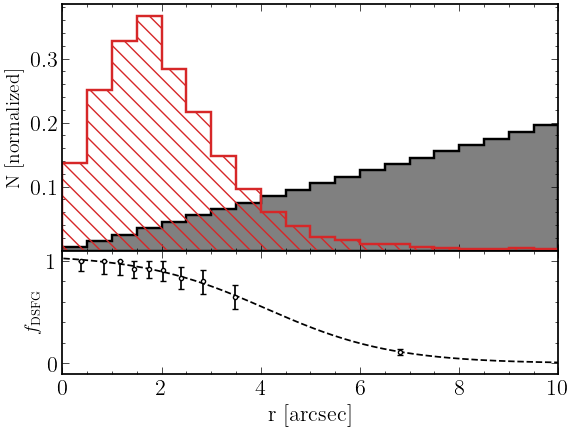

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/1052319716.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels)


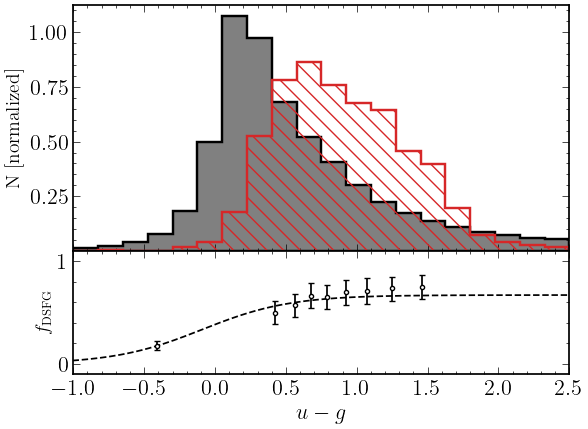

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/1052319716.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels)


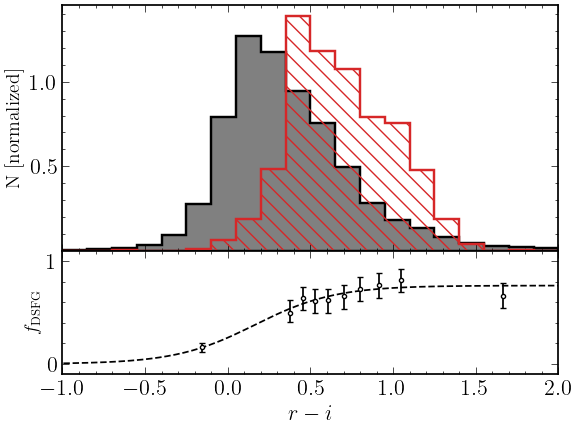

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/1052319716.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels)


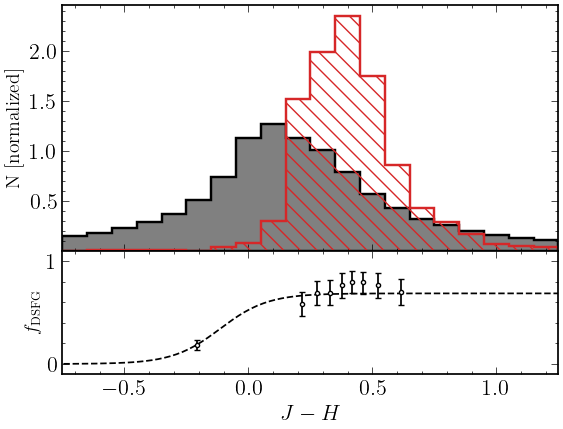

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/1052319716.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels)


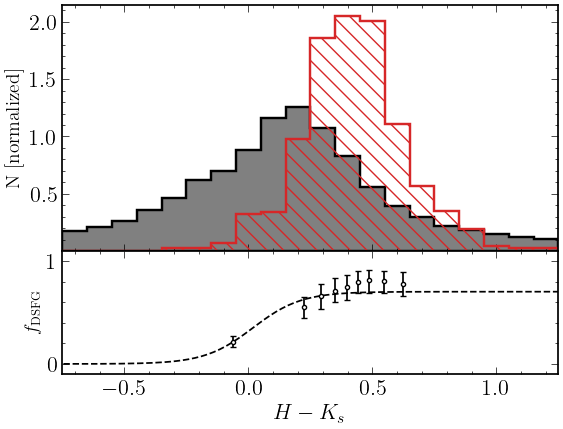

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/1052319716.py:11: RuntimeWarning: overflow encountered in exp
  return (L/(1+np.exp(k*(x-x0))))
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_1973/1052319716.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(labels)


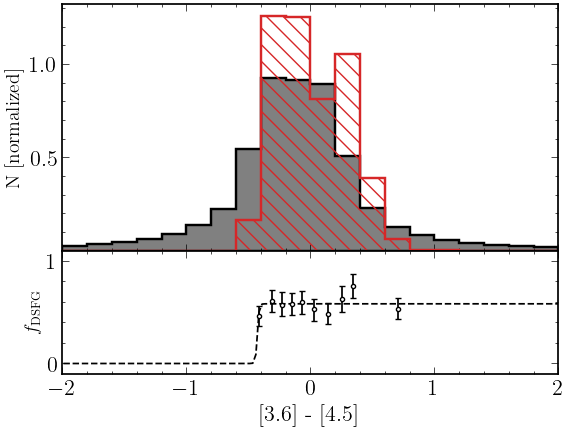

In [45]:
# All plots for DSFG against non-DSFGs
smg_frac('r_value', r'r [arcsec]', 0, 10, figure_name='Figure_5_12_part1')
smg_frac('u_g', r'$u - g$', -1, 2.5, figure_name='Figure_5_12_part2')
smg_frac('r_i', r'$r - i$', -1, 2, figure_name='Figure_5_12_part3')
smg_frac('J_H', r'$J - H$', -0.75, 1.25, figure_name='Figure_5_12_part4')
smg_frac('H_Ks', r'$H - K_s$', -0.75, 1.25, figure_name='Figure_5_12_part5')
smg_frac('36_45', r'[3.6] - [4.5]', -2, 2, figure_name='Figure_5_12_part6')